In [28]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [29]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [30]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [31]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [32]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [33]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr_diff'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS_diff'], train0_df['ffef_tr2_diff'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS_diff'], test0_df['ffef_tr2_diff'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS_diff'], np.zeros(train0_df.shape[0]), train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS_diff'], np.zeros(test0_df.shape[0]), test0_df.shape[0],1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

In [34]:
t0_df[['FEDFUNDS_diff','ffef_tr','ffef_tr2']].head(20)

,FEDFUNDS_diff,ffef_tr,ffef_tr2
DATE,,,
1962-03-31,0.056667,6.272692,2.896301
1962-06-30,0.150000,6.403498,2.960170
1962-09-30,0.240000,6.318855,3.046512
1962-12-31,0.076667,5.849439,3.203780
1963-03-31,0.043333,5.705875,3.247023
1963-06-30,-0.003333,5.628261,3.235888
1963-09-30,0.366667,6.385039,3.360453
1963-12-31,0.123333,6.778638,3.636323
1964-03-31,0.010000,7.177027,3.810980


In [35]:
t0_df[['FEDFUNDS_diff','ffef_tr_diff','ffef_tr2_diff']].head(20)

,FEDFUNDS_diff,ffef_tr_diff,ffef_tr2_diff
DATE,,,
1962-03-31,0.056667,0.819163,0.635994
1962-06-30,0.150000,0.130806,0.063869
1962-09-30,0.240000,-0.084643,0.086343
1962-12-31,0.076667,-0.469416,0.157267
1963-03-31,0.043333,-0.143564,0.043244
1963-06-30,-0.003333,-0.077614,-0.011135
1963-09-30,0.366667,0.756778,0.124565
1963-12-31,0.123333,0.393598,0.275870
1964-03-31,0.010000,0.398389,0.174657


# Load Data

In [36]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE < "2007-09-30"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (197, 22)
test_df:  (49, 22)


In [37]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS-1', 'FEDFUNDS_diff', 'gap_inf', 'gap_gdp', 'gap_ue',
       'ffef_tr', 'ffef_tr2', 'ffef_tr_diff', 'ffef_tr2_diff',
       'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

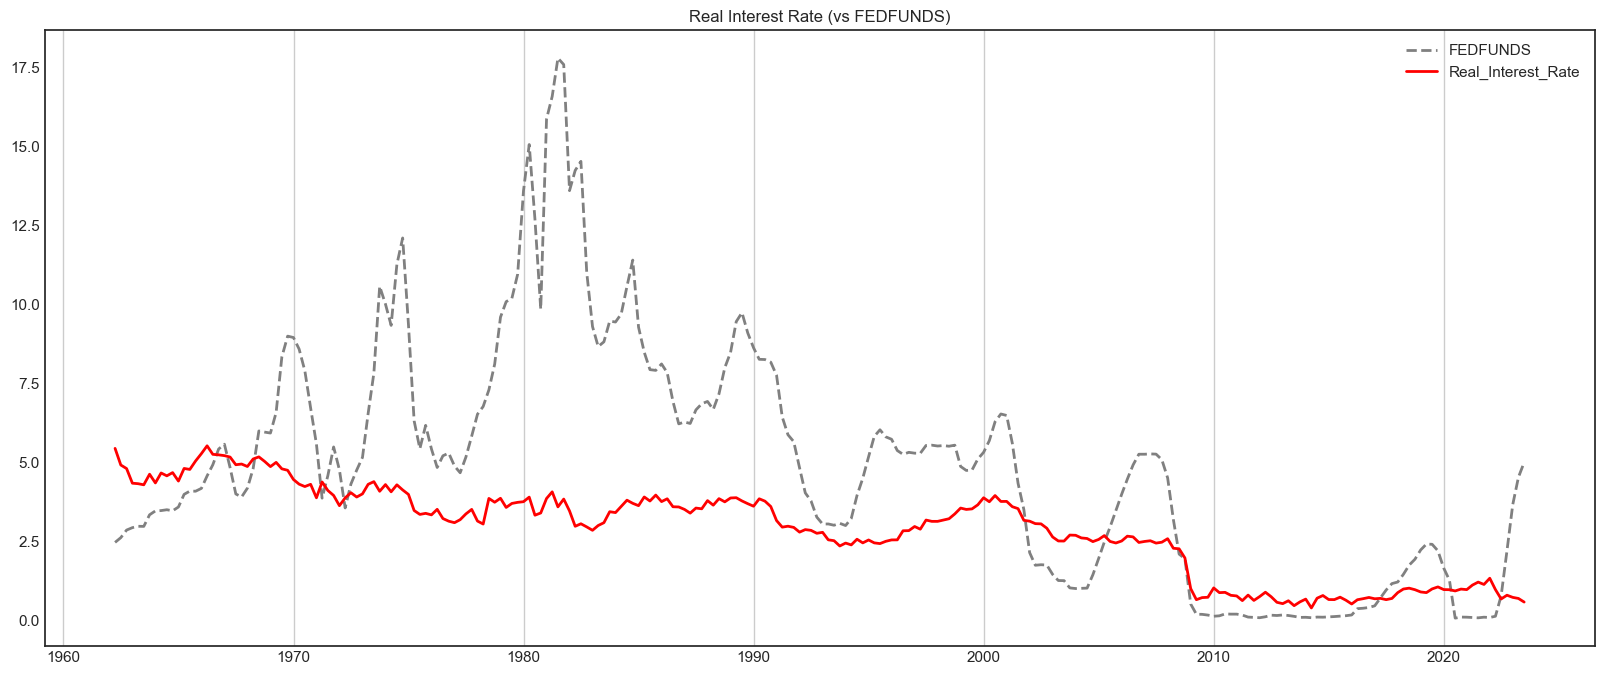

In [38]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Real Interest Rate (vs FEDFUNDS)');
plt.show()

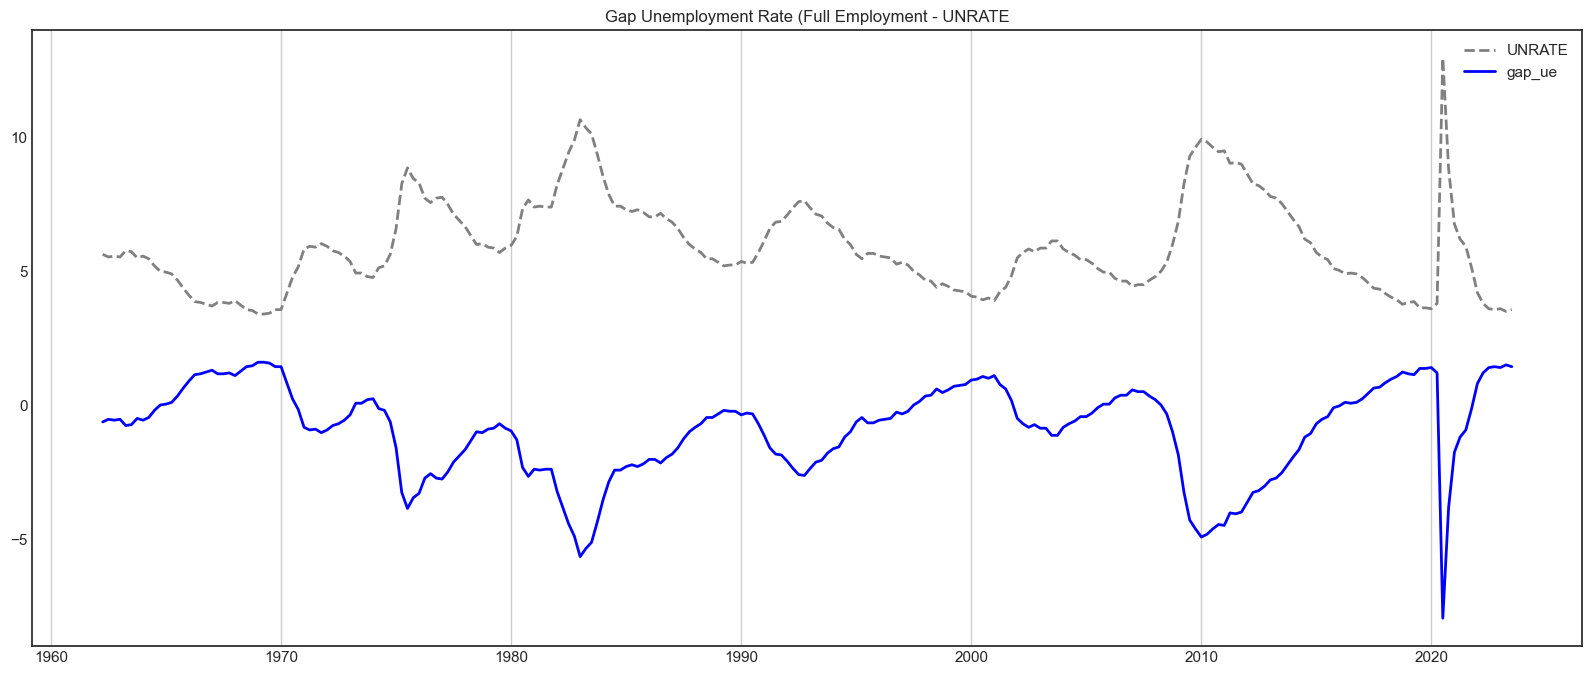

In [39]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

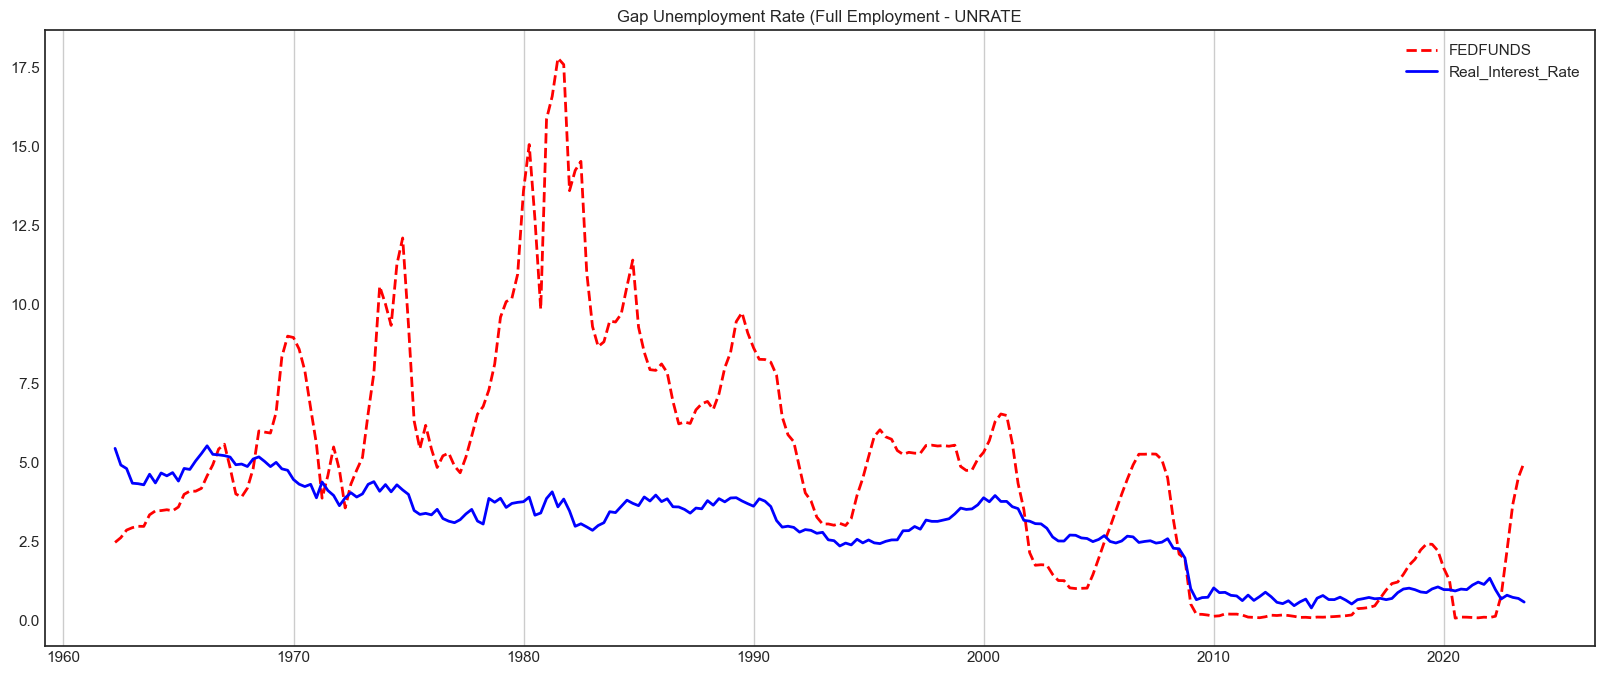

In [40]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

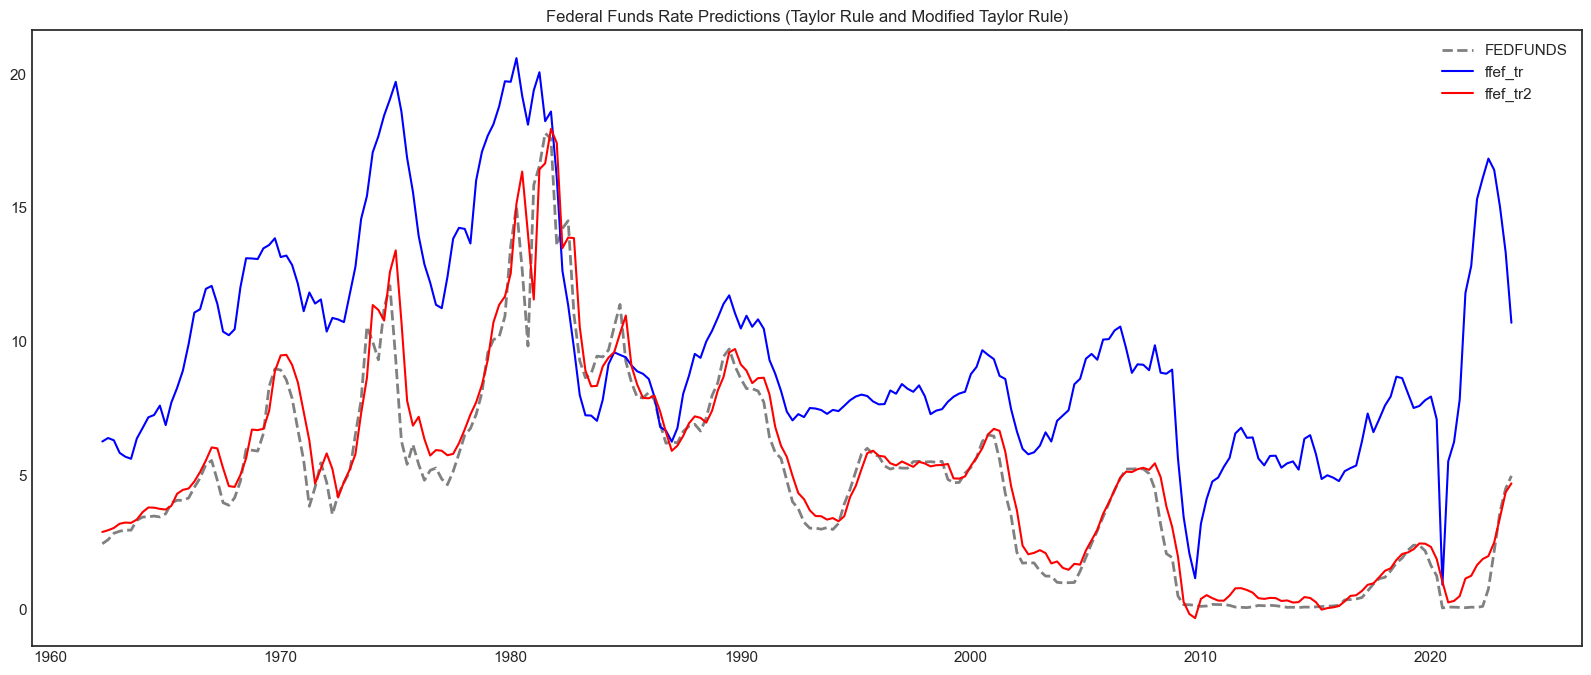

In [41]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr'], color='blue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS", "ffef_tr","ffef_tr2"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

In [42]:
case = 1  # Full Model
#case = 2  # Modified Taylor Rule
#case = 3  # Recession Model
#case = 4  # Simple Model
#case = 5  # Recession Model
#case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS_diff']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
    
elif case == 3:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1','Real_Interest_Rate']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 4:
    print('-- Simplified Model')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 5:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
else:
    print('-- Feature Selection')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

-- Full Model (Lasso Base)


In [43]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (197, 5)


# Stats Model - OLS

In [44]:
X_train_const = sm.add_constant(X_train_trf)

In [45]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FEDFUNDS_diff   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     12.50
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           1.66e-10
Time:                        19:17:32   Log-Likelihood:                -245.21
No. Observations:                 197   AIC:                             502.4
Df Residuals:                     191   BIC:                             522.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -0.0360      0.076     -0.477      0.634      -0.185       0.113
num__FEDFUNDS-1                            -0.3253      0.116     -2.795      0.006      -0.555      -0.096
num__gap_inf                                0.3303      0.091      3.612      0.000       0.150       0.511
num__gap_gdp                                0.5991      0.170      3.528      0.001       0.264       0.934
num__gap_ue                                -0.3277      0.189     -1.738      0.084      -0.700       0.044
cat__onehotencoder__recession_flag_True    -0.6948      0.207     -3.358      0.001      -1.103      -0.287
==============================================================================
Omnibus:                       61.334   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.882
Skew:                           0.701   Prob(JB):                    1.14e-182
Kurtosis:                      13.006   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [47]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

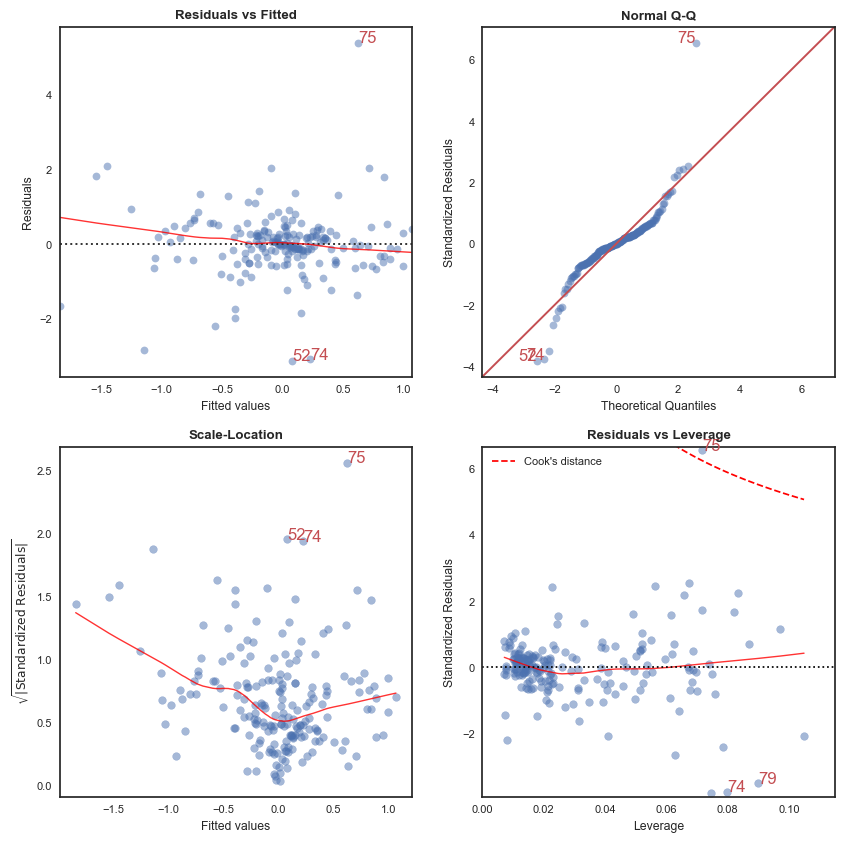

                                  Features  VIF Factor
0                                    const    1.546555
1                          num__FEDFUNDS-1    2.287976
2                             num__gap_inf    2.358400
3                             num__gap_gdp    5.618223
4                              num__gap_ue    5.587111
5  cat__onehotencoder__recession_flag_True    1.370557


In [48]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

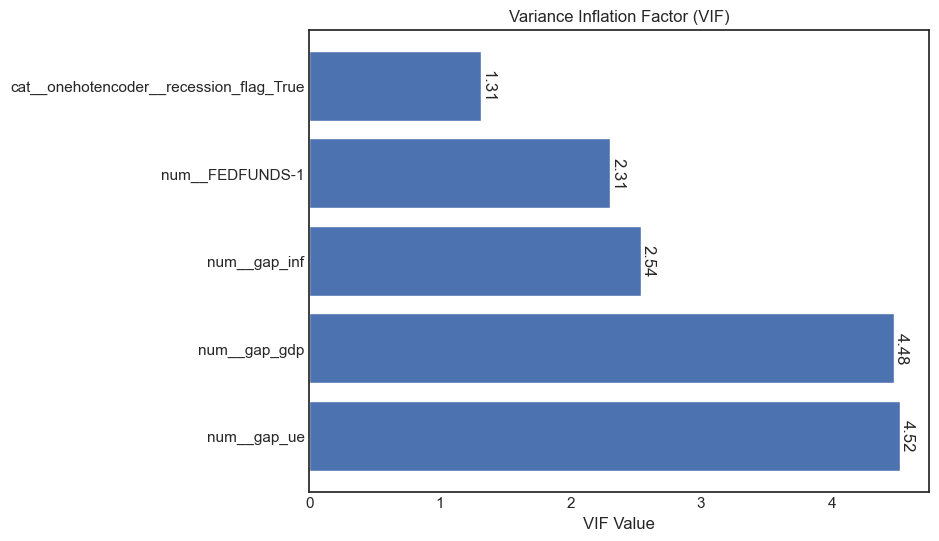

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_trf.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_trf.values, i) for i in range(X_train_trf.shape[1])]


# Sort the VIF values for plotting
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)

# Create a bar plot for VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data_sorted['Variable'], vif_data_sorted['VIF'])

# Add vertical labels to the bars
for i, value in enumerate(vif_data_sorted['VIF']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)
    
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF)')
plt.show()

In [50]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8524684906005859
Shapiro-Wilk p-value: 0.0


In [51]:
# White's Test: A significant p-value suggests the presence of heteroscedasticity.

white_test = het_white(ols_result.resid,  ols_result.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
wt_df = pd.DataFrame(zip(labels, white_test))
wt_df.columns = ['name', 'value']
round(wt_df,4)

,name,value
0,Test Statistic,94.7176
1,Test Statistic p-value,0.0000
2,F-Statistic,8.6268
3,F-Test p-value,0.0000


## Test

In [52]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 6)


In [53]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(49, 6)

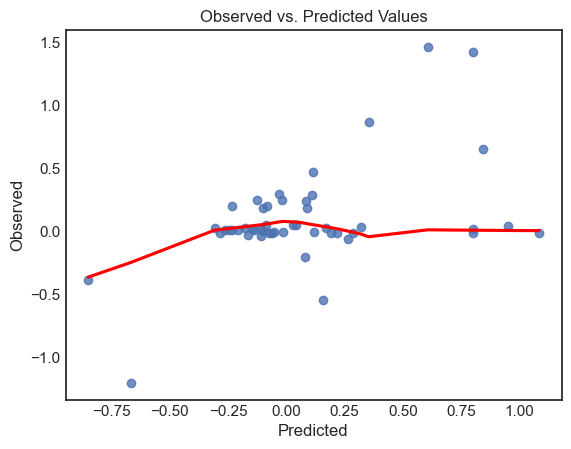

In [54]:
fitted_vals = test_pred_ols['mean']
resids = y_test - test_pred_ols['mean']


fig, ax = plt.subplots(1)

sns.regplot(x=fitted_vals, y=y_test, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

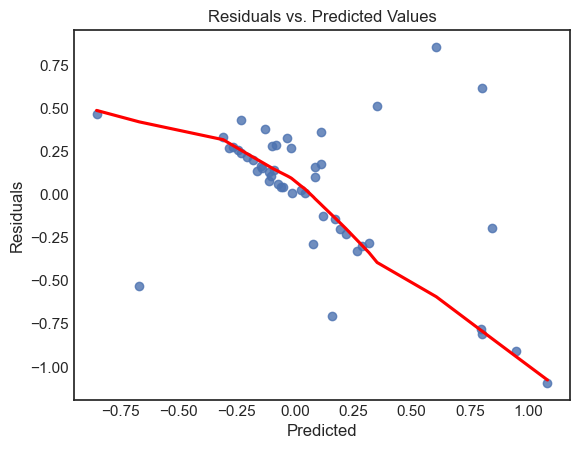

In [55]:
fig, ax = plt.subplots(1)
sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

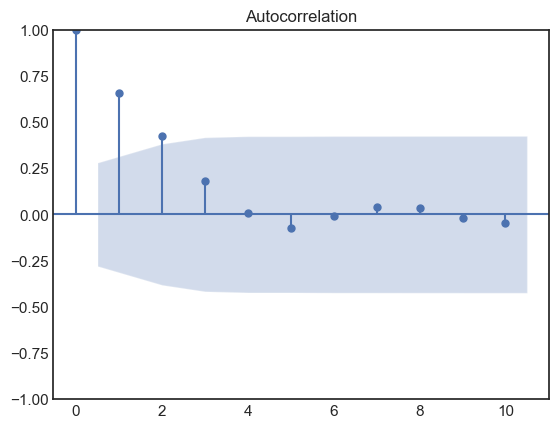

In [56]:
acf = smt.graphics.plot_acf(resids, lags=10 , alpha=0.05)
acf.show()

In [57]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Generalized Linear Model

In [58]:
X_train_const = sm.add_constant(X_train_trf)

In [59]:
#glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.inverse_power()))

glm_result = glm_model.fit(attach_wls=True,atol=1e-10)

glm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:                            GLM   Df Residuals:                      191
Model Family:                Gaussian   Df Model:                            5
Link Function:          inverse_power   Scale:                         0.89159
Method:                          IRLS   Log-Likelihood:                -265.23
Date:                Mon, 27 Nov 2023   Deviance:                       170.29
Time:                        19:17:33   Pearson chi2:                     170.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.07797
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       9.9601     26.439      0.377      0.706     -41.860      61.780
num__FEDFUNDS-1                           -52.4142     97.801     -0.536      0.592    -244.102     139.273
num__gap_inf                                7.8551     14.769      0.532      0.595     -21.091      36.801
num__gap_gdp                               58.2113    104.017      0.560      0.576    -145.659     262.081
num__gap_ue                              -262.5357    485.227     -0.541      0.588   -1213.562     688.491
cat__onehotencoder__recession_flag_True  -298.4067    562.953     -0.530      0.596   -1401.775     804.961
===========================================================================================================
"""

infl = glm_result.get_influence(observed=False)

summ_df = infl.summary_frame()
#summ_df.sort_values("cooks_d", ascending=False)[:10]

fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

plt.show()

In [60]:
train_pred_glm = glm_result.predict(X_train_const)

t = glm_result.get_prediction(X_train_const)
train_pred_glm = t.summary_frame(alpha=0.05)

In [61]:
model_stats_df = model_results('glm_train', y_train, train_pred_glm['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [62]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 6)


In [63]:
t = glm_result.get_prediction(X_test_const)
test_pred_glm = t.summary_frame(alpha=0.05)
test_pred_glm.shape

(49, 4)

In [64]:
model_stats_df = model_results('glm_test', y_test, test_pred_glm['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042
6,ols_train,0.2466,0.2309,0.7058,0.8401
7,ols_test,-0.0178,-0.1103,0.1564,0.3955
8,glm_train,0.0773,0.0580,0.8644,0.9298
9,glm_test,-0.0766,-0.1745,0.1654,0.4067


# Lasso

In [65]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.005178079454611184


In [66]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: 0.07234522025541068 Parameters: {} {'model__verbose': 0}


In [67]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [68]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
cat__onehotencoder__recession_flag_True,-0.670595
num__gap_gdp,0.539771
num__gap_inf,0.310755
num__FEDFUNDS-1,-0.300574
num__gap_ue,-0.259635


In [69]:
feature_df.index

Index(['cat__onehotencoder__recession_flag_True', 'num__gap_gdp',
       'num__gap_inf', 'num__FEDFUNDS-1', 'num__gap_ue'],
      dtype='object')

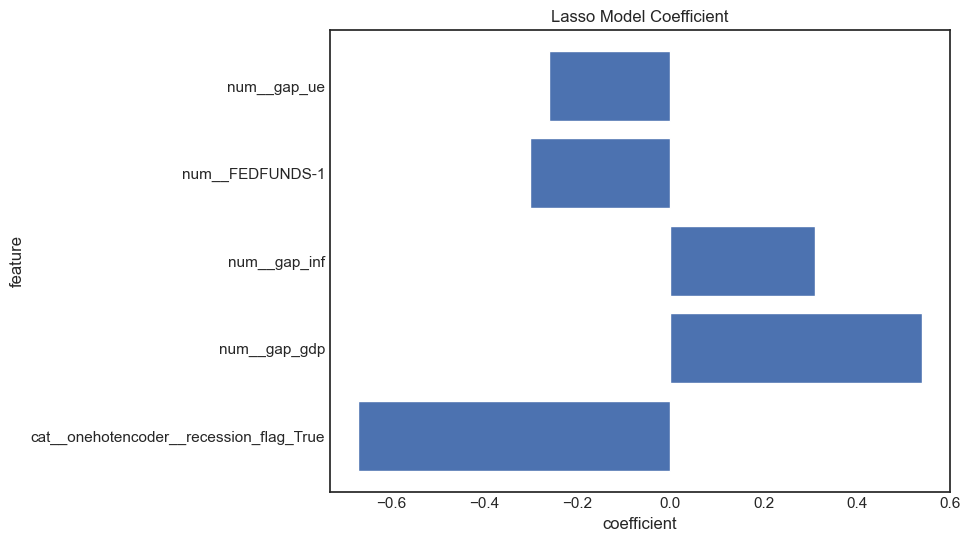

In [70]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

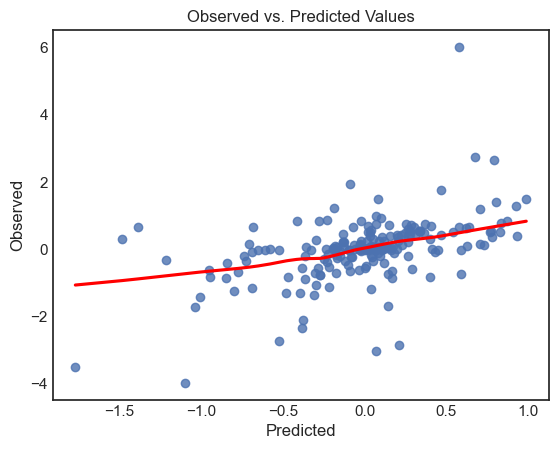

In [71]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

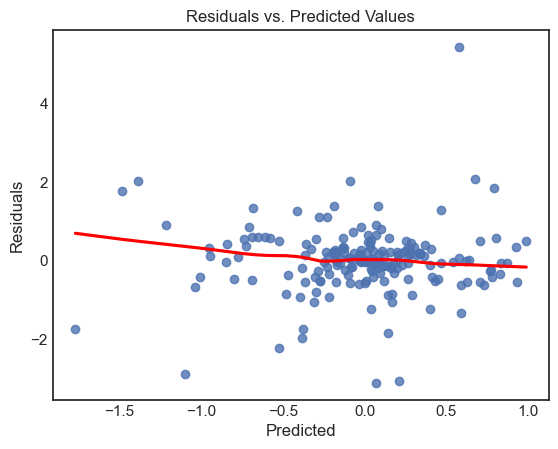

In [72]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

In [73]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.8261298988243215


In [74]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.8474975824356079
Shapiro-Wilk p-value: 0.0
Sample does not look Gaussian (reject H0 - data is not normally distributed)


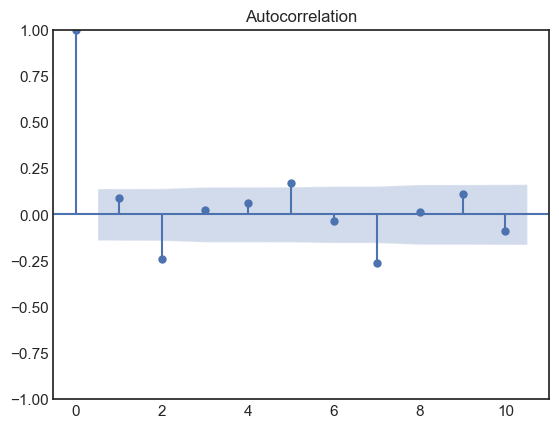

In [75]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [76]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

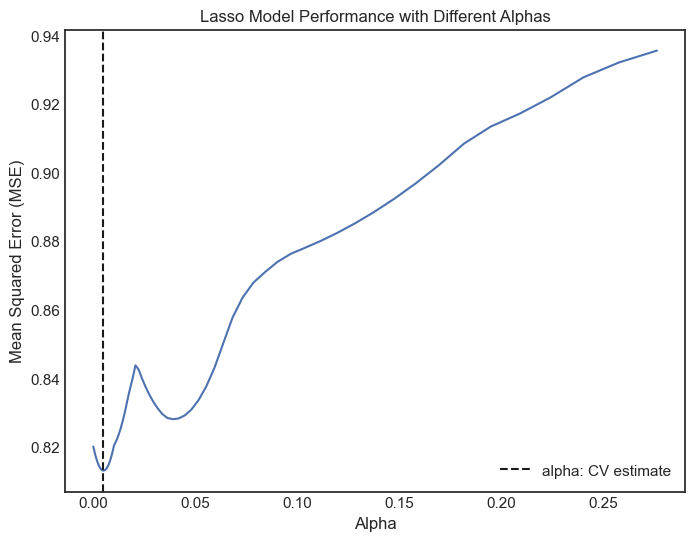

In [77]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

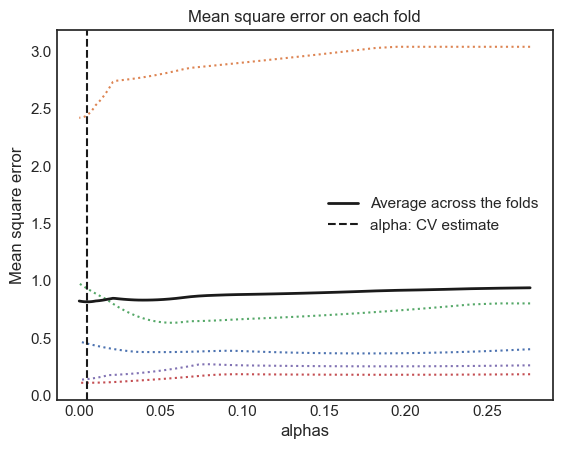

In [78]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()
#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

## Test

In [79]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_const: ', X_test_trf.shape)

X_test_const:  (49, 5)


In [80]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


In [81]:
residuals = y_test - test_pred_lasso

In [82]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

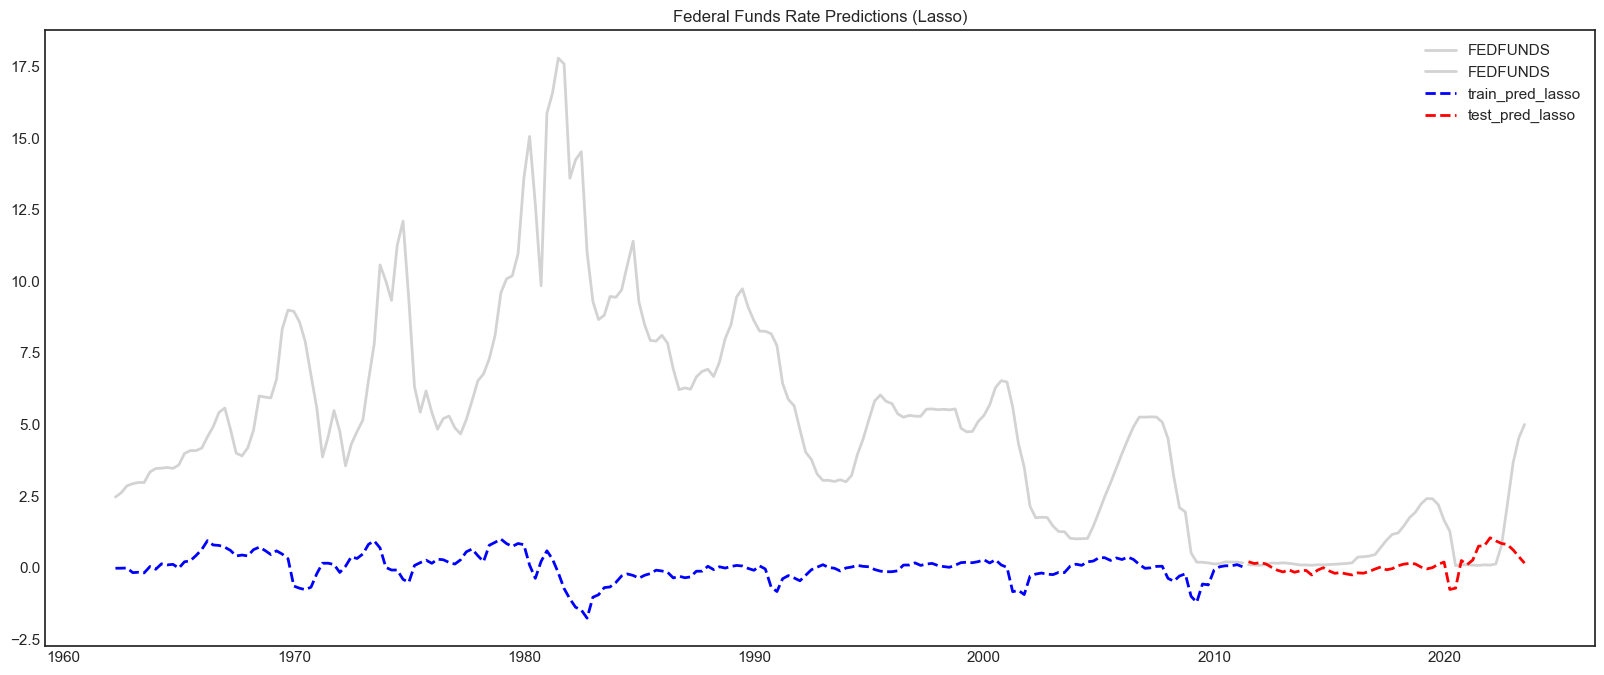

In [83]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

## Sharpe

In [84]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [85]:
explainer = None
shap_values = None

In [86]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

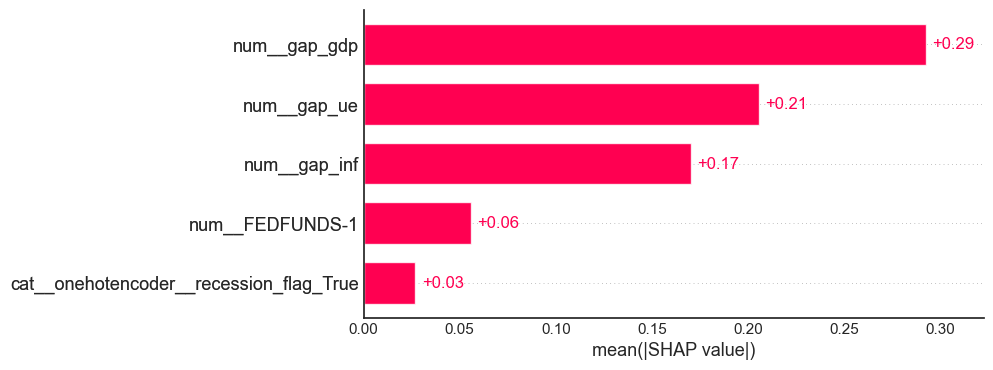

In [87]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

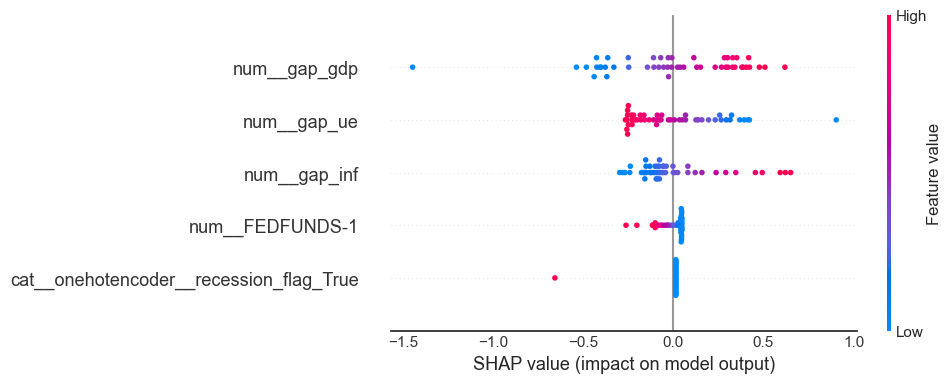

In [88]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

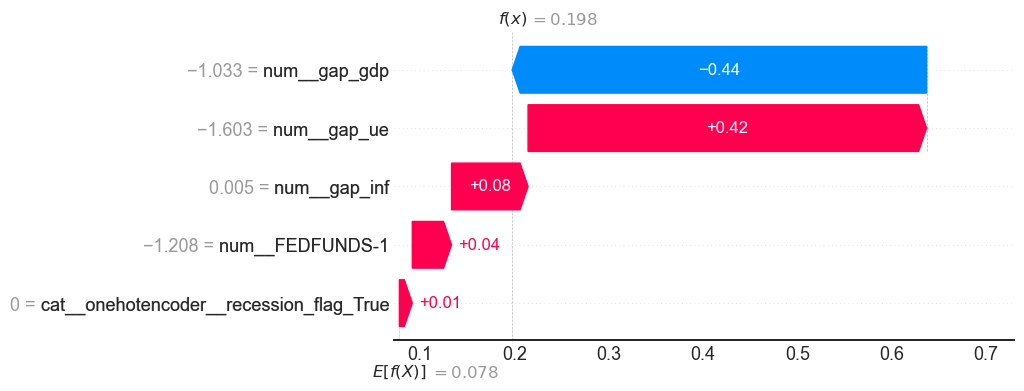

In [89]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


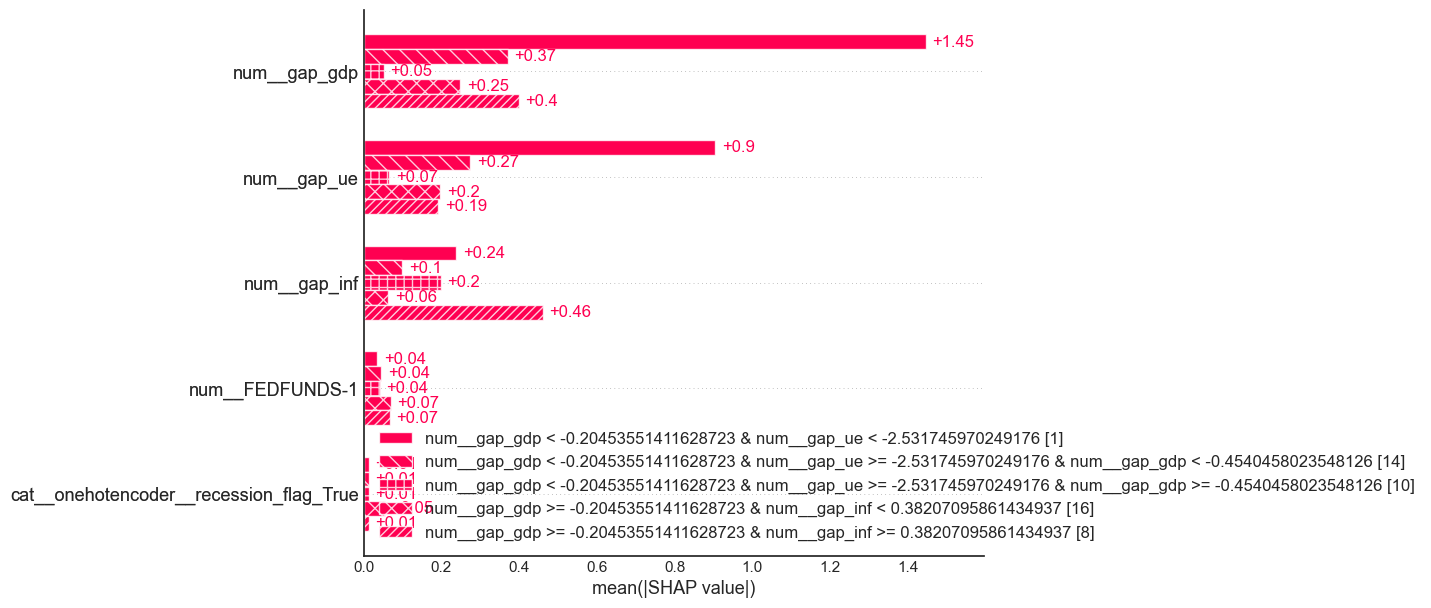

In [90]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [91]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

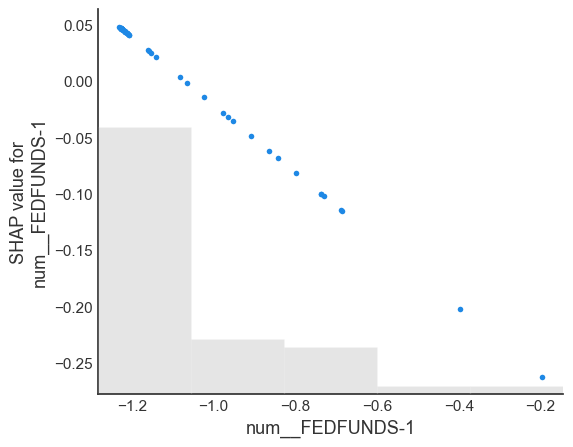

In [92]:
if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

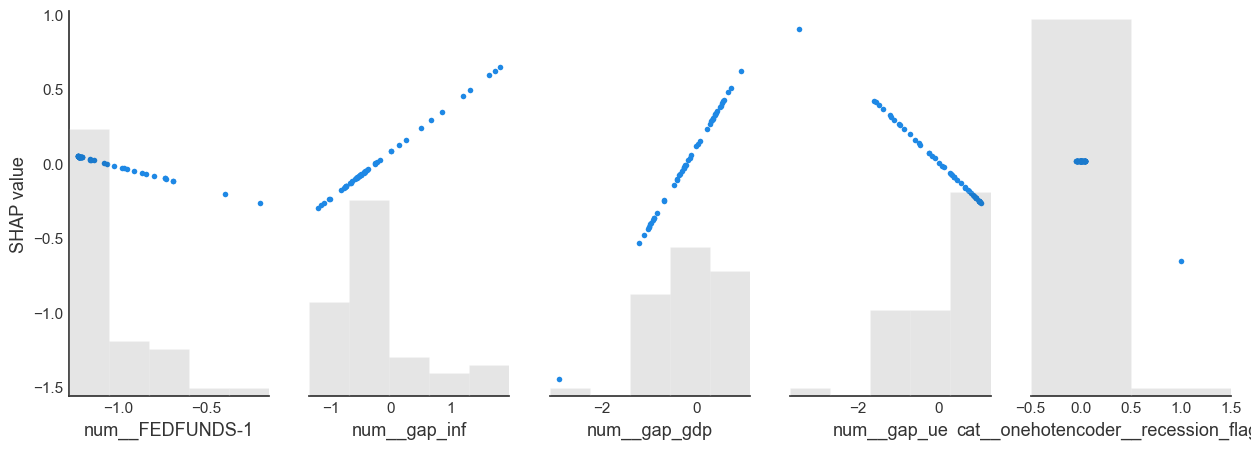

In [93]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# LGBM

In [94]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.0402790632618405 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [95]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler_num',
                                                                   RobustScaler()),
                                                                  ('imp_num',
                                                                   SimpleImputer())]),
                                                  ['FEDFUNDS-1', 'gap_inf',
                                                   'gap_gdp', 'gap_ue']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.020404898976033085, max_depth=4,
                               min_data_in_leaf=10, n_estimators=260,
                               num_leaves=49, reg_alpha=0.07714526452120027,
                               verbose=-1))])

In [96]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [97]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

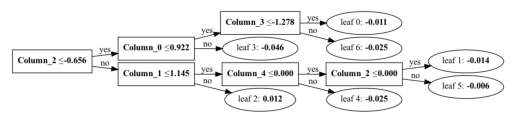

In [98]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

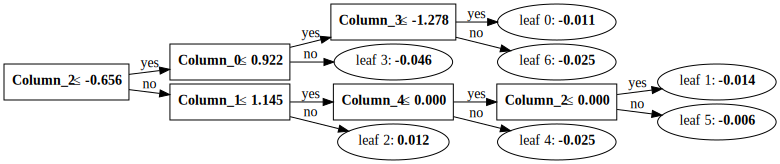

In [99]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [100]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
1,num__gap_inf,403
0,num__FEDFUNDS-1,362
2,num__gap_gdp,334
3,num__gap_ue,228
4,cat__onehotencoder__recession_flag_True,98


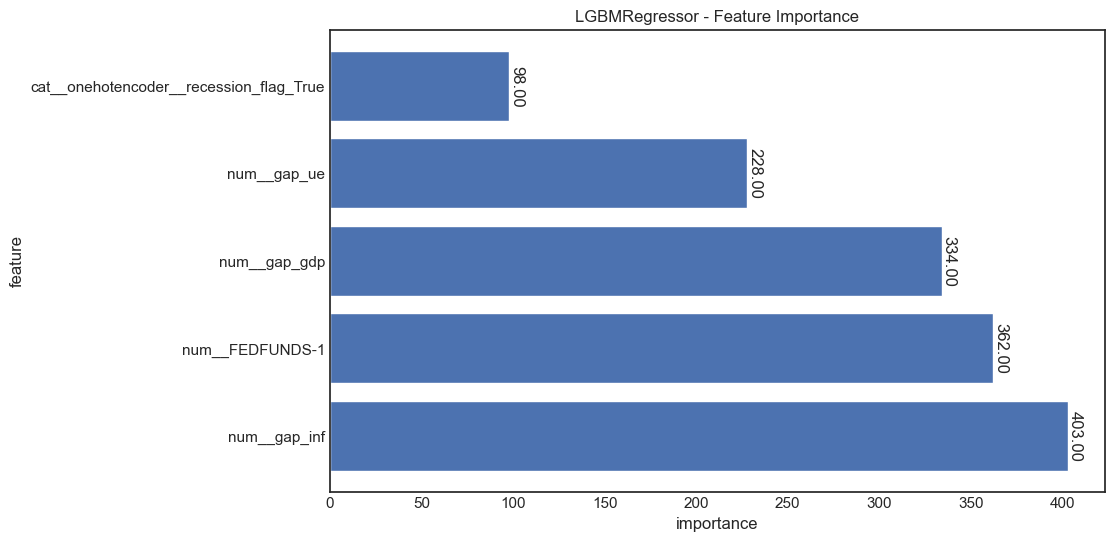

In [101]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

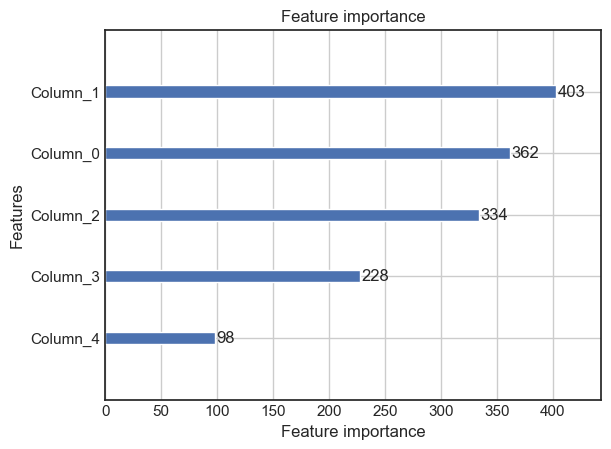

In [102]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [103]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [104]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(49,)

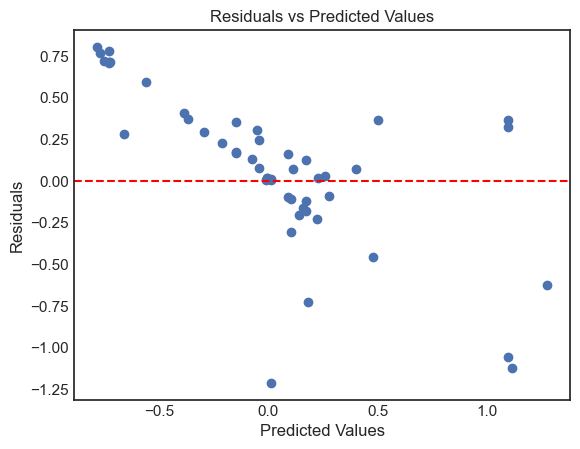

In [105]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [106]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

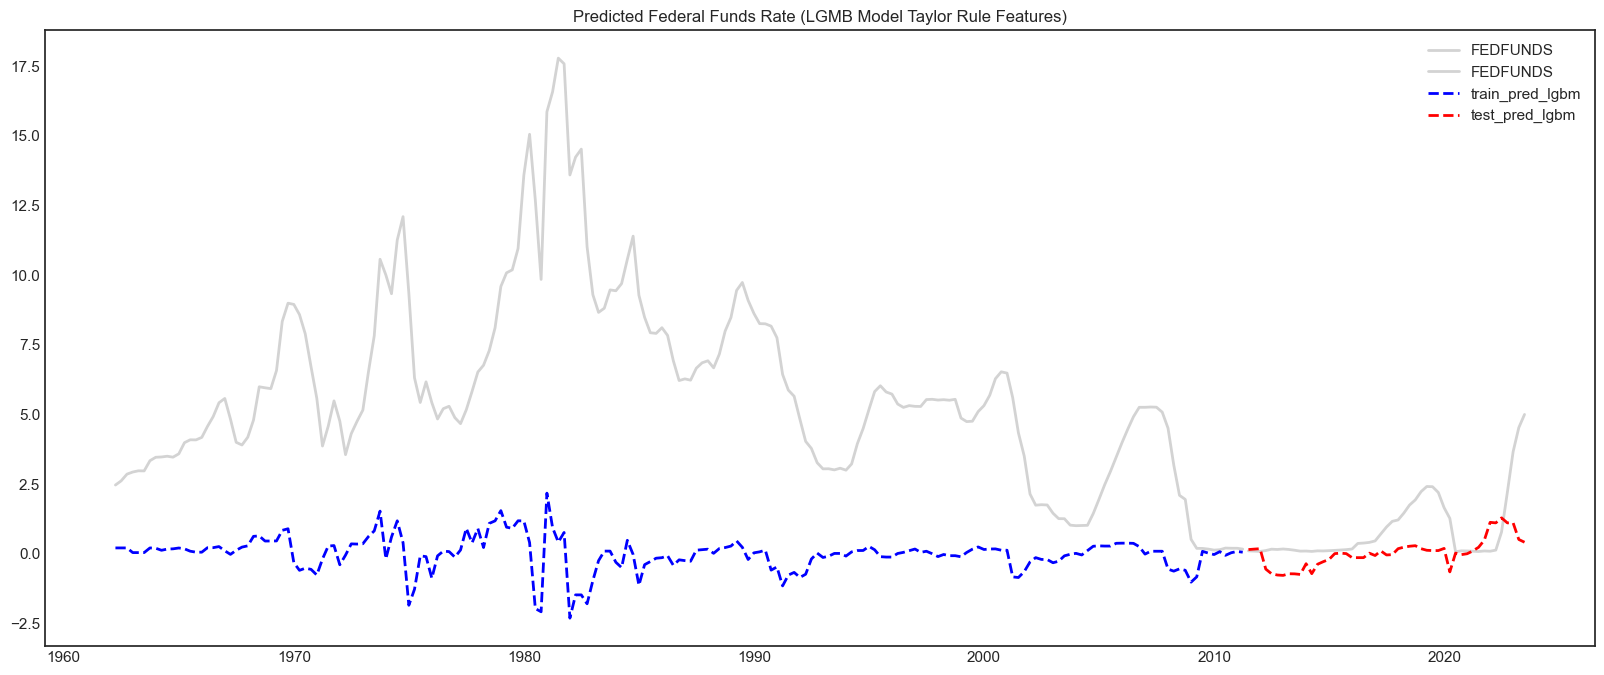

In [107]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# Sharpe

In [108]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [109]:
explainer = None
shap_values = None

In [110]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

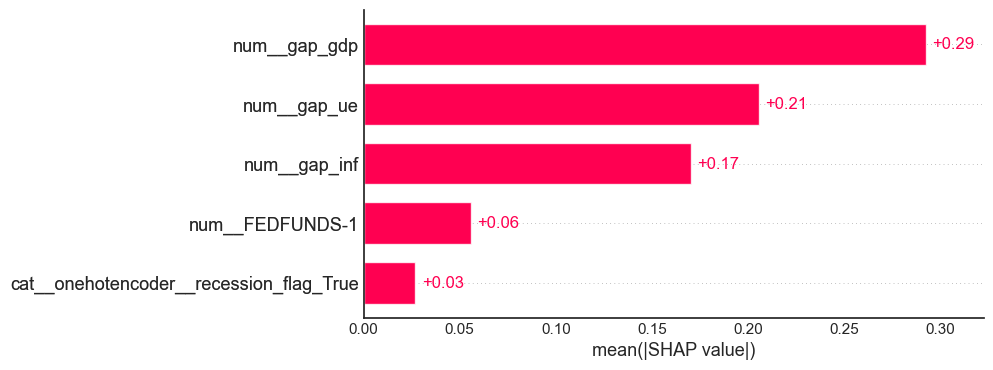

In [111]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

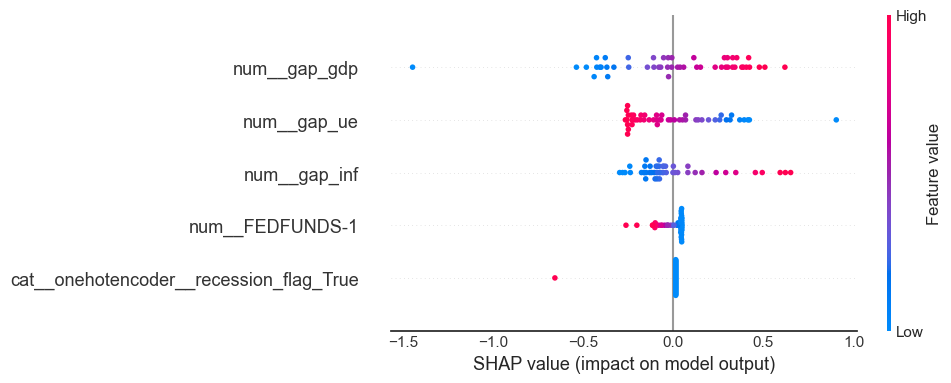

In [112]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

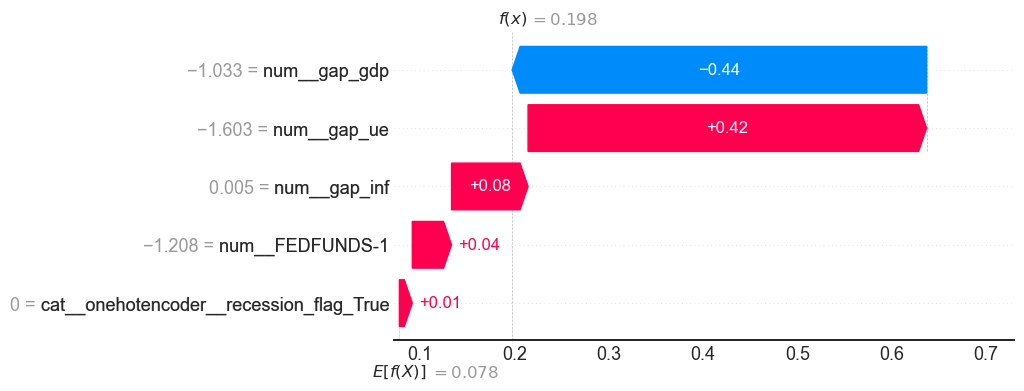

In [113]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


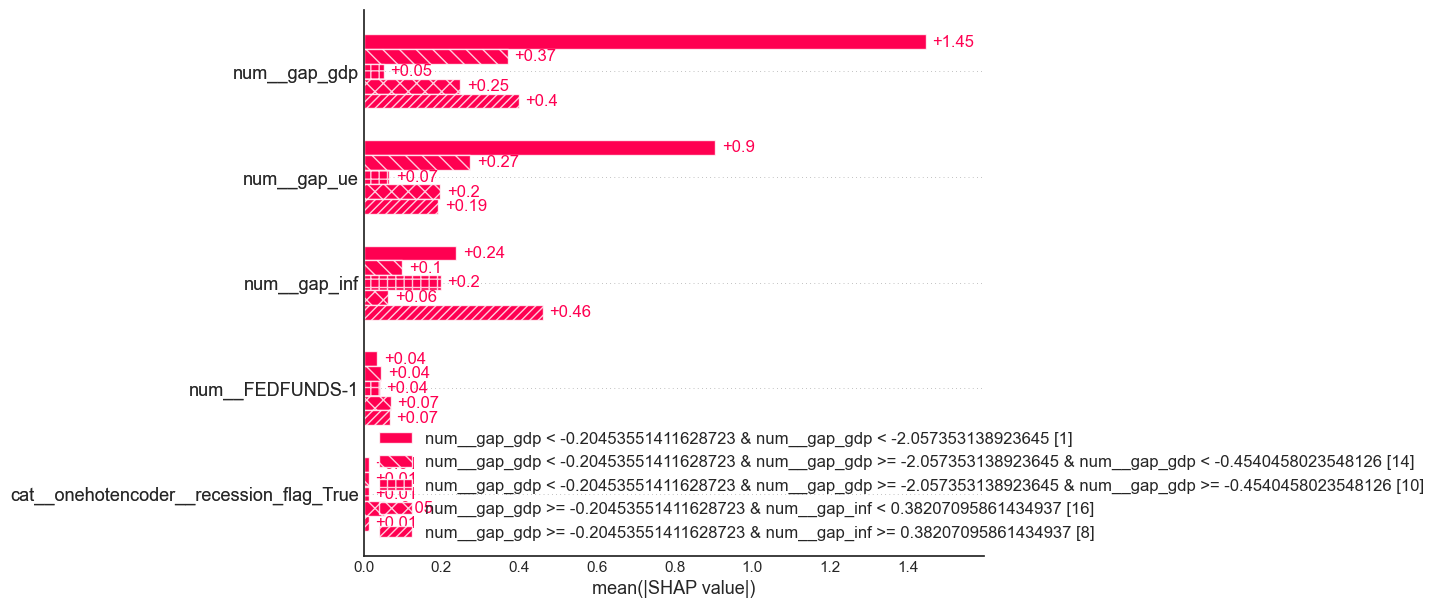

In [114]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [115]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

In [116]:
explainer_tmp = None
shap_values_tmp = None

try:
    explainer_tmp = shap.Explainer(model)
    shap_values_tmp = explainer_tmp.shap_values(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

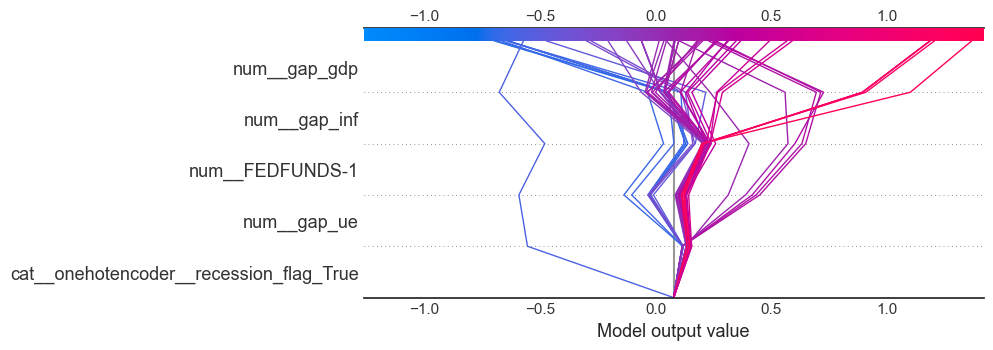

In [117]:
if (shap_values_tmp is not None):
    expected_value = explainer.expected_value
    shap.decision_plot(expected_value, shap_values_tmp, feature_names, ignore_warnings=True)

In [118]:
expected_value

0.07817930953733218

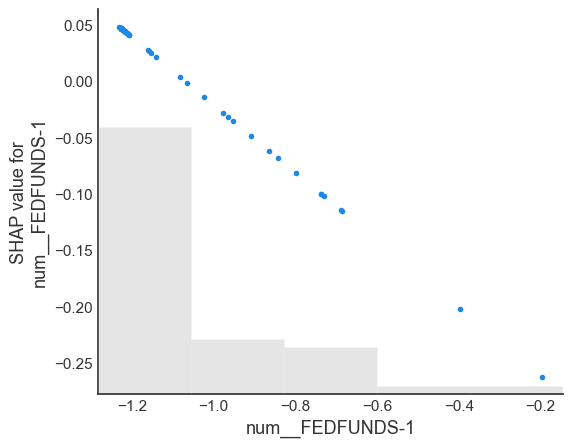

In [119]:
if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

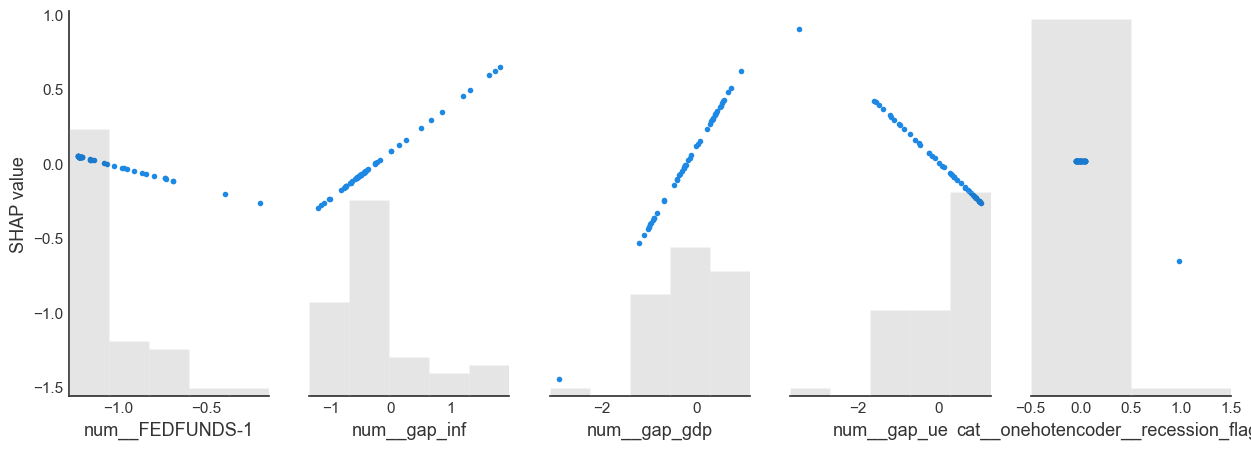

In [120]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# XGB

In [121]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.0849853164780181 Parameters: {} {'model__colsample_bytree': 0.7758614974313065, 'model__learning_rate': 0.017249308005608803, 'model__max_depth': 9, 'model__min_child_weight': 5, 'model__n_estimators': 170, 'model__reg_alpha': 0.060069680454765316, 'model__subsample': 0.8547895388034705, 'model__verbose': -1}


In [122]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.7710483003028312

In [123]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7758614974313065, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.017249308005608803, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [124]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [125]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [126]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler_num',
                                                                                                RobustScaler()),
                                                                                               ('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['FEDFUNDS-1',
                                                                                'gap_inf',
                                                                                'gap_gdp',
                                                                                'gap_ue']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]],
                                                                                                                                               dr...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1695fd030>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1696b3a60>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1695fe170>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1695fd300>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [127]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

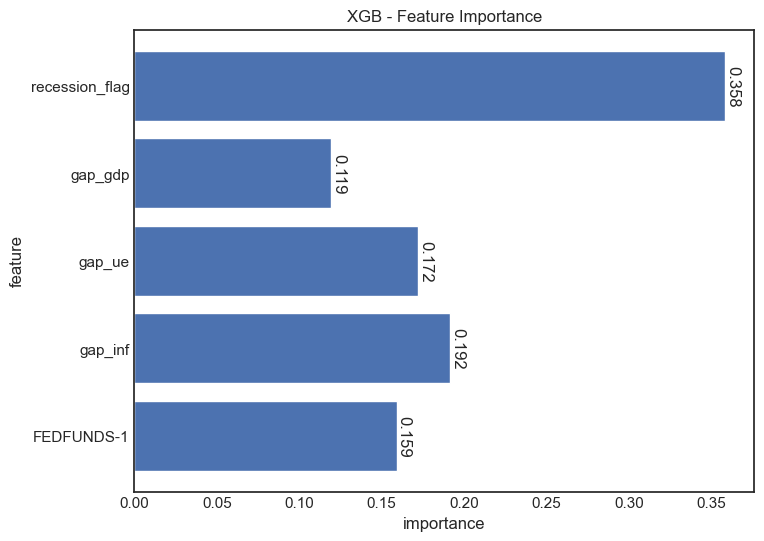

In [128]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

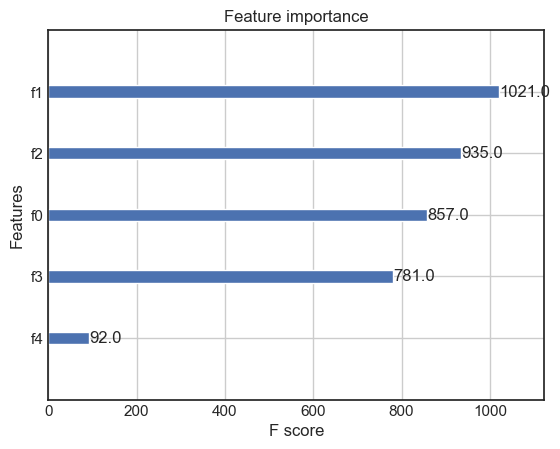

In [129]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [130]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [131]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (49,)


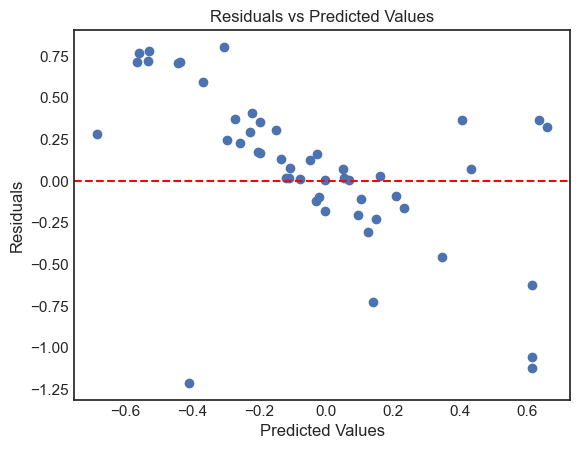

In [132]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [133]:
model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

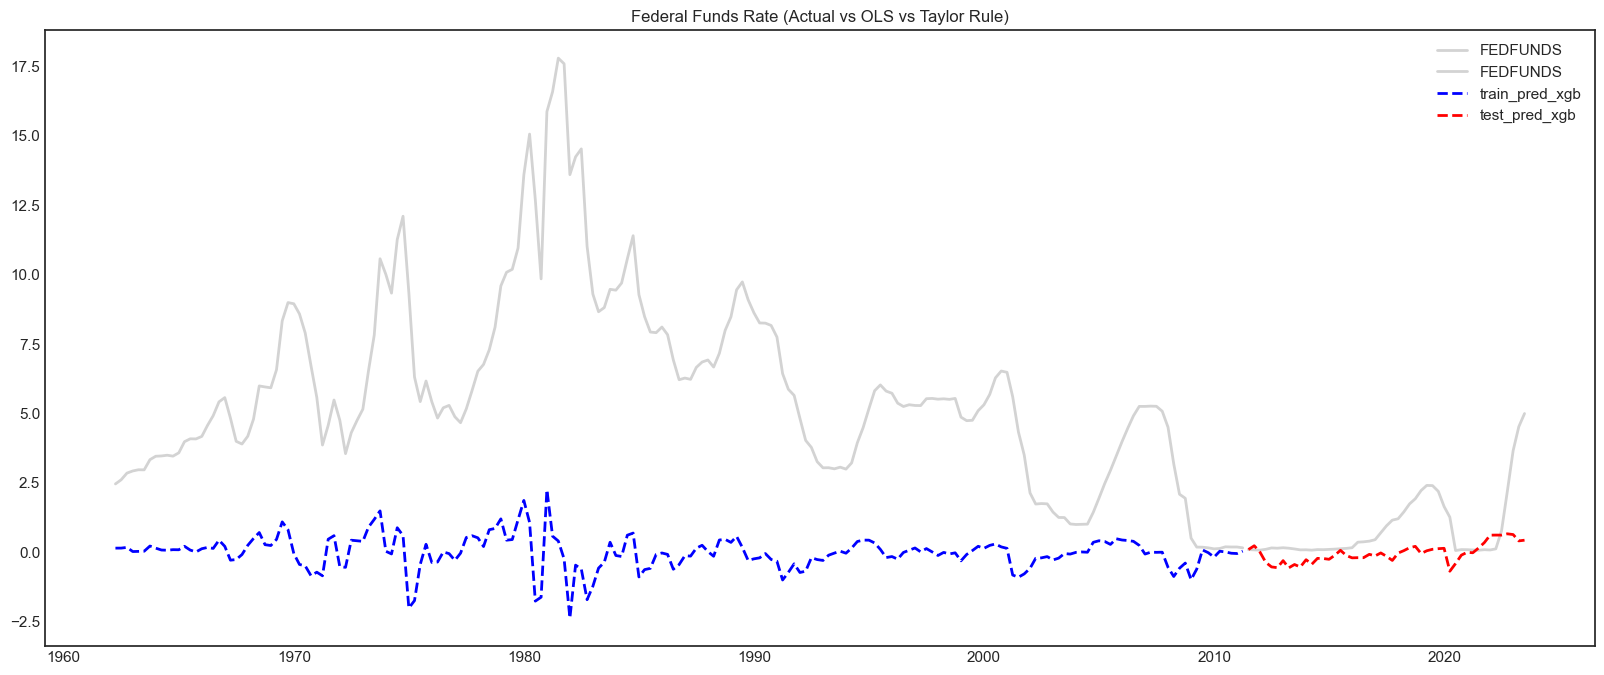

In [134]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [135]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.07100547015660777 Parameters: {} {'model__n_estimators': 50, 'model__loss': 'exponential', 'model__learning_rate': 0.1}


In [136]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.6504914123010721

In [137]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.1, loss='exponential')

In [138]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

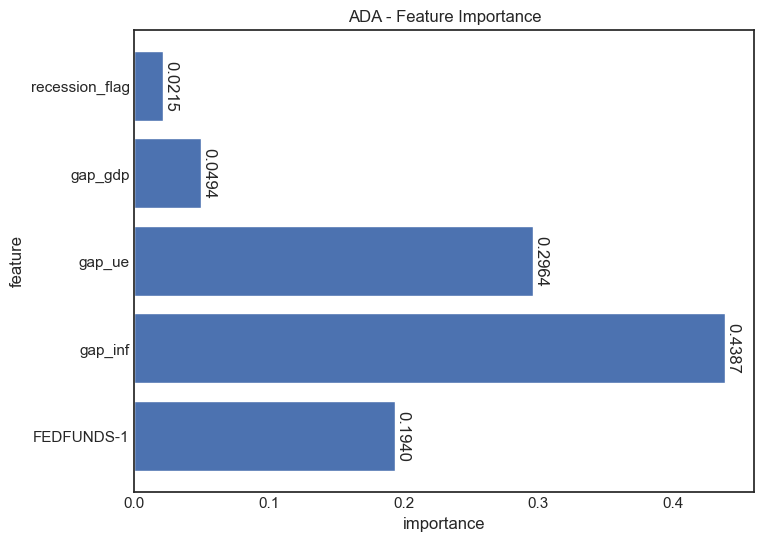

In [139]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [140]:
train_pred_ada = cv.best_estimator_.predict(X_train)
model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [141]:
test_pred_ada = cv.best_estimator_.predict(X_test)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

In [142]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,0.0328,0.0279,0.9061,0.9519
1,ffef_tr_test,-13.6332,-13.9446,2.2484,1.4995
2,ffef_tr2_train,-0.3337,-0.3406,1.2494,1.1178
3,ffef_tr2_test,0.5059,0.4954,0.0759,0.2755
4,Naive_train,-0.0001,-0.0001,0.9369,0.9680
5,Naive_test,-0.0633,-0.0633,0.1634,0.4042
6,ols_train,0.2466,0.2309,0.7058,0.8401
7,ols_test,-0.0178,-0.1103,0.1564,0.3955
8,glm_train,0.0773,0.0580,0.8644,0.9298
9,glm_test,-0.0766,-0.1745,0.1654,0.4067
